When we start learning probability we often are told the probability of an event and from there try to estimate the likelihood of various outcomes. In reality the inverse is much more common: we have data about the outcomes but don't really know what the true probability of the event is. Trying to figure out this missing parameter is referred to as Parameter Estimation.

# Discrete probability distribution

In [11]:
from scipy.special import comb
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [12]:
def binomial(from_N, choose_k, probability):
    return comb(from_N, choose_k) * np.power(probability, choose_k) * np.power((1 - probability), from_N - choose_k)

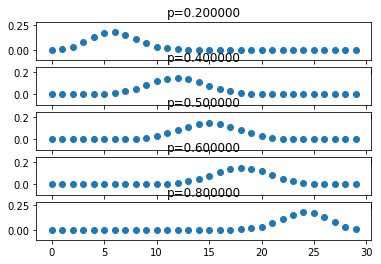

In [43]:
plt.figure(1)
for index, p in enumerate([0.2,0.4,0.5,0.6,0.8]):
    X, Y = [], []

    for x in range(30):
        Y.append(binomial(30, x, p))
        X.append(x)

    plt.subplot(5, 1, index + 1)
    plt.scatter(X, Y)
    plt.title("p=%f" % p)

Because this is a discrete probability distribution we refer to the function defining it as the Probability Mass Function

That is we know n and k but not p? After 30 tosses, we have 11 heads, what's our best guess for p?

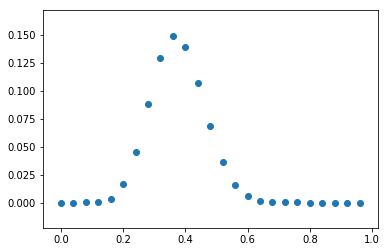

In [45]:
X = []
Y = []
for p in range(0,100,4):
    p = p/100.0
    X.append(p)
    Y.append(binomial(30,11, p))
    
plt.scatter(X, Y)

Now we can see that p=0.4 is the most likely! Actually the peak is a little less than 0.4. ... 0.3666 with period 6 but we cannot reach this number because of float precision.

There's another issue with our distribution which is less obvious: our discrete probabilities don't add up to 1! This just means that we need some sort of normalizing constant to force our values to sum up correctly.

The distribution which solves this problem is the **Beta Distribution** and it is our example of a Continous Probability Distribution. The Beta Distribution solves a very similar problem to the Binomial Distribution only for the case where we know n and k but not p

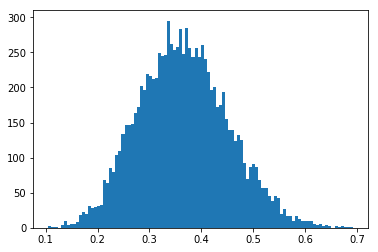

In [95]:
_ = plt.hist(np.random.beta(11,19, 10000), bins=100)

In [59]:
print ("Probability that value of omega is between 0.2 and 0.5")
scipy.special.betainc(11,19,0.5) - scipy.special.betainc(11,19,0.2)

Probability that value of omega is between 0.2 and 0.5


0.9122725863214266

In this case, let's say for first 40,000 visitors I get 300 subscribers. 

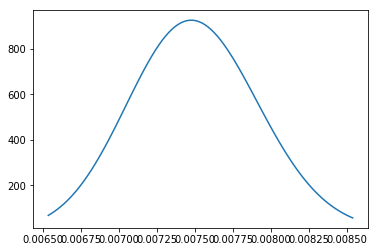

In [66]:
from scipy.stats import beta
a, b = 300, 39700
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
plt.plot(x, beta.pdf(x, a, b))

The PDF is only really useful for quickly ascertaining where the peak of a distribution is and getting a rough sense of the width and shape (which give a visual understanding of Variance and Skewness). A much better function is the Cumulative Distribution Function (CDF). The CDF, for any probability distribution, tells how probable it is that a value is below x in our distribution. 

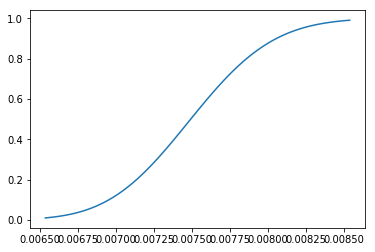

In [68]:
from scipy.stats import beta
a, b = 300, 39700
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
plt.plot(x, beta.cdf(x, a, b))

First we can easily see the median (which can even be challening to compute analytically) by visually drawing a line from the point where the cumulative probability is 0.5

In Bayesian terms, the data we have observed is our Likelihood and the information from our personal experience and MailChimp is our Prior Probability

MailChimp says the conversion rate for most people in the same space as this blog is 2.4%. This give us a starting place, but there are still several different Beta distributions we could use to model this: Beta(1,41) Beta(2,80), Beta(5,200),Beta(24,976), etc.

Remember that we can calculate our Posterior Distribution (the combination of our Likelihood and our Prior) by simply adding together the two Beta distributions.

**The more data we gather the more our Prior beliefs become diminished by evidence!**

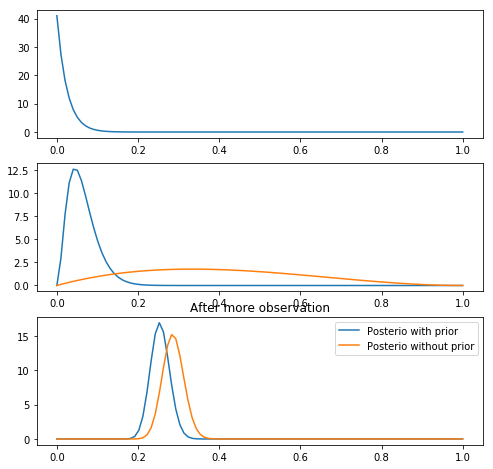

In [93]:
a, b = 1, 41
x = np.linspace(0, 1, 100)
plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
plt.plot(x, beta.pdf(x, a, b), label="Prior")
plt.subplot(3,1,2)
plt.plot(x, beta.pdf(x, a + 2, b + 3), label="Posterio with prior")
plt.plot(x, beta.pdf(x, 2, 3), label="Posterio without prior")
plt.subplot(3,1,3)
plt.title("After more observation")
plt.plot(x, beta.pdf(x, a + 86, b + 214), label="Posterio with prior")
plt.plot(x, beta.pdf(x, 86, 214), label="Posterio without prior")
plt.legend()


What about when we are not so sure about our prior? This says "I'm pretty skepitical of conversion rates less than 1%, and increasingly skeptical of them as they grow past 40%, everything else I feel equally likely about".


The problem with doing this in code is that we no longer have a nice analytical solution for calcuating our normalized Posterior! To demonstrate this let's collect some data. We've installed the tracker and our results show that in the first 12 people 2 converted.

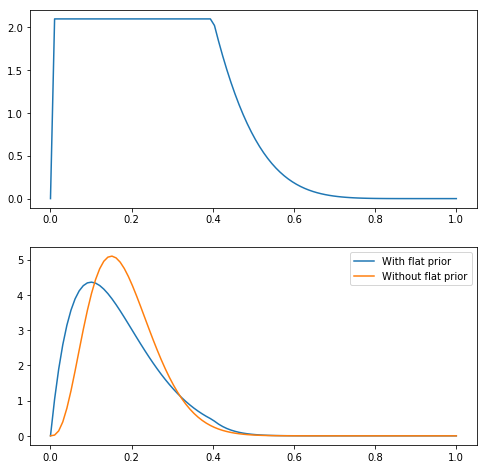

In [106]:
dx = 100
a = 2
b = 8
X = np.linspace(0, 1, dx)
Y = [beta.pdf(0.4, a, b) if 0.01 < x < 0.4 else beta.pdf(x, a, b) for x in X]
Y = Y/sum(Y)*dx

post_a = 2
post_b = 10
post_X = X
post_Y = [beta.pdf(x, post_a, post_b) for x in post_X]
post_Y = np.multiply(post_Y, Y)
post_Y = post_Y/sum(post_Y)*dx #normalize

post_without_flat_X = X
post_without_flat_Y = [beta.pdf(x, a + post_a, b + post_b) for x in post_without_flat_X]

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(X, Y)

plt.subplot(2,1,2)
plt.plot(post_X, post_Y, label="With flat prior")
plt.plot(post_without_flat_X, post_without_flat_Y, label= "Without flat prior")
plt.legend()

### Food allergy estimation

We'll denote "has an allergy" with a variable **A**. The article gives the probability of a food allergy in children as being between 4%-8% and for adults 1%-2%. For our analysis, we'll assume the middle values, but keep in mind that we could be more conservative in our estimates.

We'll use the variable **C** for "claims they have an allergy" (or that their kids do). Luckily the article states that both adults and parents of children claim that either they or their children have a food allergy 30% of the time.

Given someone claims a food allergy, what is the probability that they truly do have an allergy? - P(A∣C)

Given that we know both P(A)P(A) and P(C)P(C) we can use Bayes' Theorem!

P(A|C) = (P(C|A) * P(A)) / P(C)

I'm going to assume that if you do have a food allergy, then there is a 100% chance you will claim to have one. 
P(C|A) = 1

Given the data we have, if a parent claims their child has a food allergy there's a 20% chance that child truly does and if your friend claims they have a food allergy there's only a 5% chance.